# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
import numpy as np
from glob import glob
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


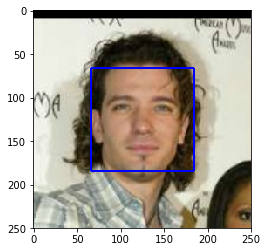

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[1])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    import cv2
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
The face detector performs correctly on all 100 of the first 100 human faces, but also falsely identifies 11 of the first 100 dog files as human faces.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]


## done: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_perf_list=[]
for i in range(human_files_short.shape[0]):
    img=human_files_short[i]
    if face_detector(img):
        human_perf_list.append(1)
    else:
        human_perf_list.append(0)
print( "face detection performance on humans: ", np.mean(human_perf_list)  )     
dog_perf_list=[]
for i in range(dog_files_short.shape[0]):
    img=dog_files_short[i]
    if face_detector(img):
        dog_perf_list.append(1)
    else:
        dog_perf_list.append(0)
print( "face detection performance on dogs: ", np.mean(dog_perf_list)  )   

face detection performance on humans:  1.0
face detection performance on dogs:  0.11


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

Depending on the application, this could be a reasonable expectation from the user (sending in applications for jobs or passports, for example).  However, it's easy to imagine many applications where photos come in and it's necessary to identify the presence of a humn or a face even though the picture may not be frontal (images from a security camera, for instance).  
By trying it on a few images, it seems that the face detection does a decent job even on images that are not frontal (see the Macron example below).  The eye, smile, left-eye and right-eye detectors seem to go a good job. These 4 and others are available in the Haarcascades repository.

The profile detector from the Haarcascades seems much more picky. (it seems to return FALSE every time a second eye shows up).
In these cases, it would be possible to declare the presence of a human using an OR condition (if a frontal face or certain other features are detected).  

Testing on a short set of human and dog files indicates that face_detector, profile_detector, and detectors of smile (lips), eye, left eye and right eye have high sensitivity (return TRUE for human faces), but smile and eye detectors return true on dogs as well. Final classication as a human face could come from an using OR logic : 

__            face_detector OR profile_detector OR lefteye_detector OR righteye_detector__  
Do not use smile detector or eye detector for this purpose, due to the reason mentioned above.  See below for displayed results.

__Udacity notes__
We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

__Below is the work on the optional part__

In [52]:
## (Optional) done: Report the performance of another [please see some experiments below] 
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.
import cv2
profile_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_profileface.xml')
eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml')
smile_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_smile.xml')
righteye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_righteye_2splits.xml')
lefteye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_lefteye_2splits.xml')
# face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')  

def profile_face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = profile_cascade.detectMultiScale(gray)
    return len(faces) > 0

def eye_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = eye_cascade.detectMultiScale(gray)
    return len(faces) > 0

def smile_detector(img_path):  ## Note: this just seems to mean human lips
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = smile_cascade.detectMultiScale(gray)
    return len(faces) > 0

def lefteye_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = lefteye_cascade.detectMultiScale(gray)
    return len(faces) > 0

def righteye_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = righteye_cascade.detectMultiScale(gray)
    return len(faces) > 0

def test_for_all_features( imag_path):
    if profile_face_detector(imag_path):
        print('Human profile: Found')
    else: print('Human profile: Not Found')
    if smile_detector(imag_path):
        print('Smile: Found')
    else: print('Smile: Not Found')
    if eye_detector(imag_path):
        print('Eye: Found')
    else: print('Eye: Not Found')
    if lefteye_detector(imag_path):
        print('Left eye: Found')
    else: print('Left eye: Not Found')
    if righteye_detector(imag_path):
        print('Right eye: Found')
    else: print('Right eye: Not Found')

In [54]:
import matplotlib.pyplot as plt                        
%matplotlib inline    
import matplotlib.image as mpimg                      

def face_test_and_show( img_path ):
    img=mpimg.imread(img_path)
    if face_detector(img_path): 
        print('Face of a person found') 
    else: print('No frontal human face found')
    plt.imshow(img)
    plt.show()

In [ ]:
def show_face_and_test_all(img_path):
    face_test_and_show( img_path )
    test_for_all_features(img_path)

No face found


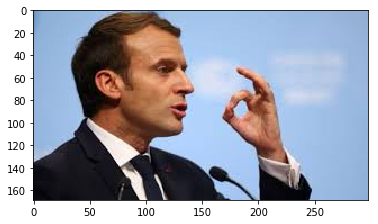

Human profile: Found
Smile: Found
Eye: Found
Left eye: Not Found
Right eye: Found


In [55]:
show_face_and_test_all('human_test/macron_profile.jpg') #The simple face detection fails on this image which not a frontal.  
#But *other features* show up correctly.  Note the correct identification of left and right eyes

Face of a person found


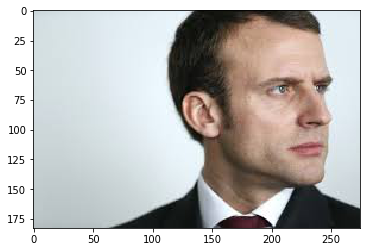

Human profile: Not Found
Smile: Found
Eye: Found
Left eye: Found
Right eye: Found


In [64]:
show_face_and_test_all('human_test/macron_tilted.jpg') #The second eye is visible here and 
#although the shot is not frontal, face detection works, but profile view returns false (in my testing, any time a second eye is seen)
#all other features correctly identified.

Face of a person found


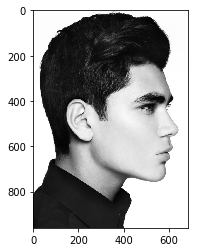

Human profile: Not Found
Smile: Found
Eye: Found
Left eye: Not Found
Right eye: Found


In [73]:
show_face_and_test_all('human_test/side_man.jpg') #again profile detector is not correct

__Performance of all these detectors on sample of 100 human and 100 dog images__

In [72]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## done: Test the performance of the profile_face_detector algorithm 
## on the images in human_files_short and dog_files_short.

#In each list, the first sublist is for human images and the second for dog images
profile_perf_list=[[],[]]
smile_perf_list=[[],[]]
eye_perf_list=[[],[]]
lefteye_perf_list=[[],[]]
righteye_perf_list=[[],[]]

for i in range(human_files_short.shape[0]):
    img=human_files_short[i]
    
    if profile_face_detector(img): profile_perf_list[0].append(1) 
    else: profile_perf_list[0].append(0)
        
    if smile_detector(img): smile_perf_list[0].append(1) 
    else: smile_perf_list[0].append(0)
        
    if eye_detector(img): eye_perf_list[0].append(1) 
    else: eye_perf_list[0].append(0)
       
    if lefteye_detector(img): lefteye_perf_list[0].append(1) 
    else: lefteye_perf_list[0].append(0) 
        
    if righteye_detector(img): righteye_perf_list[0].append(1) 
    else: righteye_perf_list[0].append(0) 
        
for i in range(dog_files_short.shape[0]):
    img=dog_files_short[i]
    
    if profile_face_detector(img): profile_perf_list[1].append(1) 
    else: profile_perf_list[1].append(0)
        
    if smile_detector(img): smile_perf_list[1].append(1) 
    else: smile_perf_list[1].append(0)
        
    if eye_detector(img): eye_perf_list[1].append(1) 
    else: eye_perf_list[1].append(0)
       
    if lefteye_detector(img): lefteye_perf_list[1].append(1) 
    else: lefteye_perf_list[1].append(0) 
        
    if righteye_detector(img): righteye_perf_list[1].append(1) 
    else: righteye_perf_list[1].append(0) 

print( "Profile detection: Performance on humans: ", np.mean(profile_perf_list[0]), ", on dogs: ",  np.mean(profile_perf_list[1])) 
print( "Smile detection: Performance on humans: ", np.mean(smile_perf_list[0]), ", on dogs: ",  np.mean(smile_perf_list[1])) 
print( "Eye detection: Performance on humans: ", np.mean(eye_perf_list[0]), ", on dogs: ",  np.mean(eye_perf_list[1])) 
print( "Left eye detection: Performance on humans: ", np.mean(lefteye_perf_list[0]), ", on dogs: ",  np.mean(lefteye_perf_list[1])) 
print( "Right eye detection: Performance on humans: ", np.mean(righteye_perf_list[0]), ", on dogs: ",  np.mean(righteye_perf_list[1]))  

Profile detection: Performance on humans:  0.5 on dogs:  0.02
Smile detection: Performance on humans:  0.99 on dogs:  1.0
Eye detection: Performance on humans:  0.96 on dogs:  0.69
Left eye detection: Performance on humans:  0.82 on dogs:  0.18
Right eye detection: Performance on humans:  0.9 on dogs:  0.15


Hence, the idea that the final classication as a human face could come from an using OR logic : face_detector OR profile_detector OR lefteye_detector OR righteye_detector.  Do not use smile detector, eye detector for this purpose because these two have low specifcity - performing very well on dogs as well.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [12]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 3s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [13]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [14]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [15]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
The dog detector correctly avoided both type I and type II errors on the first 100 human and the first 100 dog images.  That is, it returned FALSE on all the 100 human images and TRUE on all the 100 dog images.

In [23]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_perf_list=[]
for i in range(human_files_short.shape[0]):
    img=human_files_short[i]
    if dog_detector(img):
        human_perf_list.append(1)
    else:
        human_perf_list.append(0)
print( "Dog detection performance on humans: ", np.mean(human_perf_list)  )     
dog_perf_list=[]
for i in range(dog_files_short.shape[0]):
    img=dog_files_short[i]
    if dog_detector(img):
        dog_perf_list.append(1)
    else:
        dog_perf_list.append(0)
print( "Dog detection performance on dogs: ", np.mean(dog_perf_list)  ) 

Dog detection performance on humans:  0.0
Dog detection performance on dogs:  1.0


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [16]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 101.39it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

I experimented with a variety of architectures and chose the one below.  It has good performance on the test set (11.7%). It is relatively small and simple and has less than 20,000 trainable parameters. Since most of the parameters are from the densely connected layers, I found it useful to just have a single such layer, the output layer.  
The relu activation function is much better than the sigmoid ones because of the vanishing gradients problem in the case of the latter. 
My final architecture is only 1 layer deeper than the one in the hint and does not significantly increase the number of parameters. 
The GAP layer seems perform better than having a global max in the last layer. My guess for this is that it is because the throwing away of information is less severe.

In [25]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()


###done: Define your architecture.
model.add(Conv2D(filters=8, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=16, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, kernel_size=2, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=2, strides=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2)) 
# model.add(Dropout(0.2))
# model.add(Conv2D(filters=128, kernel_size=2, strides=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2)) 
# model.add(Dropout(0.2))
# model.add(Conv2D(filters=256, kernel_size=2, strides=2, padding='same', activation='relu'))
model.add(GlobalAveragePooling2D())
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.3))
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(133, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 8)       104       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 8)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 16)      528       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 32)        2080      
__________

### Compile the Model

In [26]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [27]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 200 #(it had 11.7% accuracy on the test set. But with 100 we already get good accuracy of about 4%)

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/200
6680/6680 [==============================] - 18s 3ms/step - loss: 4.8847 - acc: 0.0088 - val_loss: 4.8771 - val_acc: 0.0108
Epoch 2/200
6680/6680 [==============================] - 17s 3ms/step - loss: 4.8610 - acc: 0.0100 - val_loss: 4.8556 - val_acc: 0.0156
Epoch 3/200
6680/6680 [==============================] - 17s 3ms/step - loss: 4.8250 - acc: 0.0157 - val_loss: 4.8304 - val_acc: 0.0180
Epoch 4/200
6680/6680 [==============================] - 17s 3ms/step - loss: 4.8007 - acc: 0.0168 - val_loss: 4.8101 - val_acc: 0.0168
Epoch 5/200
6680/6680 [==============================] - 17s 3ms/step - loss: 4.7803 - acc: 0.0190 - val_loss: 4.7987 - val_acc: 0.0180
Epoch 6/200
6680/6680 [==============================] - 17s 3ms/step - loss: 4.7581 - acc: 0.0198 - val_loss: 4.7800 - val_acc: 0.0240
Epoch 7/200
6680/6680 [==============================] - 17s 3ms/step - loss: 4.7351 - acc: 0.0237 - val_loss: 4.7632 - val_acc: 0.0251
E

Epoch 28/200
6680/6680 [==============================] - 17s 3ms/step - loss: 4.2646 - acc: 0.0677 - val_loss: 4.4639 - val_acc: 0.0551
Epoch 29/200
6680/6680 [==============================] - 17s 3ms/step - loss: 4.2449 - acc: 0.0711 - val_loss: 4.4546 - val_acc: 0.0515
Epoch 30/200
6680/6680 [==============================] - 17s 3ms/step - loss: 4.2319 - acc: 0.0699 - val_loss: 4.4367 - val_acc: 0.0623
Epoch 31/200
6680/6680 [==============================] - 17s 3ms/step - loss: 4.2181 - acc: 0.0749 - val_loss: 4.4205 - val_acc: 0.0563
Epoch 32/200
6680/6680 [==============================] - 17s 3ms/step - loss: 4.1993 - acc: 0.0768 - val_loss: 4.3879 - val_acc: 0.0587
Epoch 33/200
6680/6680 [==============================] - 17s 3ms/step - loss: 4.1855 - acc: 0.0810 - val_loss: 4.3860 - val_acc: 0.0443
Epoch 34/200
6680/6680 [==============================] - 17s 3ms/step - loss: 4.1707 - acc: 0.0792 - val_loss: 4.3763 - val_acc: 0.0551
Epoch 35/200
6680/6680 [=================

Epoch 86/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.7010 - acc: 0.1425 - val_loss: 4.1505 - val_acc: 0.1042
Epoch 87/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.6959 - acc: 0.1479 - val_loss: 4.1186 - val_acc: 0.0982
Epoch 88/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.6811 - acc: 0.1493 - val_loss: 4.0686 - val_acc: 0.1018
Epoch 89/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.6848 - acc: 0.1543 - val_loss: 4.1163 - val_acc: 0.1018
Epoch 90/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.6765 - acc: 0.1476 - val_loss: 4.1463 - val_acc: 0.0886
Epoch 91/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.6638 - acc: 0.1554 - val_loss: 4.2477 - val_acc: 0.0898
Epoch 92/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.6607 - acc: 0.1536 - val_loss: 4.1690 - val_acc: 0.0982
Epoch 93/200
6680/6680 [=================

Epoch 117/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.5081 - acc: 0.1855 - val_loss: 4.1484 - val_acc: 0.1006
Epoch 118/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.4978 - acc: 0.1798 - val_loss: 4.1610 - val_acc: 0.1126
Epoch 119/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.4787 - acc: 0.1828 - val_loss: 4.2672 - val_acc: 0.0958
Epoch 120/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.4987 - acc: 0.1853 - val_loss: 4.0135 - val_acc: 0.1114
Epoch 121/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.4826 - acc: 0.1870 - val_loss: 4.3257 - val_acc: 0.1042
Epoch 122/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.4851 - acc: 0.1784 - val_loss: 4.0410 - val_acc: 0.1042
Epoch 123/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.4766 - acc: 0.1856 - val_loss: 4.1500 - val_acc: 0.1090
Epoch 124/200
6680/6680 [=========

Epoch 148/200
6680/6680 [==============================] - 17s 2ms/step - loss: 3.3567 - acc: 0.1999 - val_loss: 4.3115 - val_acc: 0.1090
Epoch 149/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.3502 - acc: 0.2097 - val_loss: 4.2219 - val_acc: 0.1138
Epoch 150/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.3593 - acc: 0.2004 - val_loss: 4.1757 - val_acc: 0.1006
Epoch 151/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.3541 - acc: 0.2040 - val_loss: 4.1040 - val_acc: 0.1078
Epoch 152/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.3286 - acc: 0.2118 - val_loss: 4.1486 - val_acc: 0.1186
Epoch 153/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.3415 - acc: 0.2087 - val_loss: 4.3255 - val_acc: 0.0970
Epoch 154/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.3328 - acc: 0.2099 - val_loss: 4.1170 - val_acc: 0.1305
Epoch 155/200
6680/6680 [=========

Epoch 180/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.2383 - acc: 0.2269 - val_loss: 4.0939 - val_acc: 0.1174
Epoch 181/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.2337 - acc: 0.2256 - val_loss: 3.9574 - val_acc: 0.1293
Epoch 182/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.2367 - acc: 0.2198 - val_loss: 4.0352 - val_acc: 0.1353
Epoch 183/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.2324 - acc: 0.2199 - val_loss: 4.1900 - val_acc: 0.1162
Epoch 184/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.2237 - acc: 0.2268 - val_loss: 3.9524 - val_acc: 0.1293
Epoch 185/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.2204 - acc: 0.2281 - val_loss: 4.0104 - val_acc: 0.1293
Epoch 186/200
6680/6680 [==============================] - 17s 3ms/step - loss: 3.2139 - acc: 0.2256 - val_loss: 4.0732 - val_acc: 0.1162
Epoch 187/200
6680/6680 [=========

### Load the Model with the Best Validation Loss

In [28]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [29]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 11.7225%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [30]:
bottleneck_features = np.load('/data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [31]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [32]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [33]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 292us/step - loss: 12.0532 - acc: 0.1287 - val_loss: 10.2277 - val_acc: 0.2371
Epoch 2/20
6680/6680 [==============================] - 2s 245us/step - loss: 9.6985 - acc: 0.2978 - val_loss: 9.6783 - val_acc: 0.3066
Epoch 3/20
6680/6680 [==============================] - 2s 240us/step - loss: 9.2754 - acc: 0.3614 - val_loss: 9.5060 - val_acc: 0.3317
Epoch 4/20
6680/6680 [==============================] - 2s 240us/step - loss: 9.0072 - acc: 0.3883 - val_loss: 9.2972 - val_acc: 0.3317
Epoch 5/20
6680/6680 [==============================] - 2s 244us/step - loss: 8.6833 - acc: 0.4168 - val_loss: 8.9701 - val_acc: 0.3593
Epoch 6/20
6680/6680 [==============================] - 2s 243us/step - loss: 8.4892 - acc: 0.4388 - val_loss: 8.8599 - val_acc: 0.3749
Epoch 7/20
6680/6680 [==============================] - 2s 243us/step - loss: 8.3801 - acc: 0.4519 - val_loss: 8.8837 - val_acc: 0.3760

### Load the Model with the Best Validation Loss

In [34]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [35]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy with transfer from VGG16: %.4f%%' % test_accuracy)

Test accuracy with transfer from VGG16: 43.7799%


### Predict Dog Breed with the Model

In [36]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [37]:
VGG16_predict_breed('/data/lfw/Zinedine_Zidane/Zinedine_Zidane_0002.jpg')

58892288/58889256 [==============================] - 2s 0us/step


'in/082.Havanese'

In [38]:
VGG16_predict_breed('/data/dogImages/083.Ibizan_hound/Ibizan_hound_05642.jpg') #correct

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras.  These are already in the workspace, at /data/bottleneck_features.  If you wish to download them on a different machine, they can be found at:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  

The above architectures are downloaded and stored for you in the `/data/bottleneck_features/` folder.

This means the following will be in the `/data/bottleneck_features/` folder:

`DogVGG19Data.npz`
`DogResnet50Data.npz`
`DogInceptionV3Data.npz`
`DogXceptionData.npz`



### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('/data/bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [17]:
### done: Obtain bottleneck features from another pre-trained CNN.
import numpy as np
resnetbottleneck_features = np.load('/data/bottleneck_features/DogResnet50Data.npz')
train_R50ext = resnetbottleneck_features['train']
valid_R50ext = resnetbottleneck_features['valid']
test_R50ext = resnetbottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
The output of Resnet_50 is already of shape (1,1,2048).  So any convolutional or max-pooling layers don't make sense.  The output layer has have 133 nodes and softmax activation would make sense.  Using dropout at the output layer is not a good idea.  So that effectively leaves us with only one option (to add some dense hidden layers between Resnet output and the 133-node output layer).  This hugely increases the number of parameters to be trained and gives no gain in performance over a single output layer.  So, I have decided to stick with the simplest architecture which merely trains weights for a single 133-node softmax output layer. 


In [18]:
### done: Define your architecture.
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

R50ext_model = Sequential()
R50ext_model.add(GlobalAveragePooling2D(input_shape=train_R50ext.shape[1:]))
R50ext_model.add(Dense(133, activation='softmax'))

R50ext_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [53]:
# ### done: Define your architecture.
# from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
# from keras.layers import Dropout, Flatten, Dense
# from keras.models import Sequential

# Resnet50_model = Sequential()
# Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
# Resnet50_model.add(Dense(256, activation='relu')) #tried 64 and 128 nodes also -  huge increase in number of parameters, no performance gain at all)
# Resnet50_model.add(Dropout(0.3))

# Resnet50_model.add(Dense(133, activation='softmax'))
# Resnet50_model.summary()

### (IMPLEMENTATION) Compile the Model

In [19]:
### done: Compile the model.
R50ext_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [20]:
### done: Train the model.
from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.R50ext.hdf5', 
                               verbose=1, save_best_only=True)

R50ext_model.fit(train_R50ext, train_targets, 
          validation_data=(valid_R50ext, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 337us/step - loss: 1.6400 - acc: 0.5979 - val_loss: 0.8146 - val_acc: 0.7437
Epoch 2/20
6680/6680 [==============================] - 1s 214us/step - loss: 0.4339 - acc: 0.8644 - val_loss: 0.6490 - val_acc: 0.7880
Epoch 3/20
6680/6680 [==============================] - 1s 216us/step - loss: 0.2641 - acc: 0.9138 - val_loss: 0.6796 - val_acc: 0.8024
Epoch 4/20
6680/6680 [==============================] - 1s 211us/step - loss: 0.1728 - acc: 0.9448 - val_loss: 0.6528 - val_acc: 0.8144
Epoch 5/20
6680/6680 [==============================] - 1s 209us/step - loss: 0.1263 - acc: 0.9599 - val_loss: 0.6544 - val_acc: 0.8120
Epoch 6/20
6680/6680 [==============================] - 1s 210us/step - loss: 0.0904 - acc: 0.9735 - val_loss: 0.6706 - val_acc: 0.8275
Epoch 7/20
6680/6680 [==============================] - 1s 211us/step - loss: 0.0639 - acc: 0.9811 - val_loss: 0.6679 - val_acc: 0.8311
E

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [21]:
### done: Load the model weights with the best validation loss.
R50ext_model.load_weights('saved_models/weights.best.R50ext.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [22]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
R50ext_predictions = [np.argmax(R50ext_model.predict(np.expand_dims(feature, axis=0))) for feature in test_R50ext]

# report test accuracy
R50ext_test_accuracy = 100*np.sum(np.array(R50ext_predictions)==np.argmax(test_targets, axis=1))/len(R50ext_predictions)
print('Test accuracy with transfer from Resnet50: %.4f%%' % R50ext_test_accuracy)

Test accuracy with transfer from Resnet50: 78.2297%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [23]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def R50ext_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = R50ext_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [24]:
R50ext_predict_breed('images/Welsh_springer_spaniel_08203.jpg') # testing...

94658560/94653016 [==============================] - 1s 0us/step


'in/130.Welsh_springer_spaniel'

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [25]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg                      
%matplotlib inline 

def your_dog_breed(img_path):
    img=mpimg.imread(img_path)
    if dog_detector(img_path):
        print('This dog is a ', R50ext_predict_breed(img_path))
        plt.imshow(img)
        plt.show()
    else:
        if face_detector(img_path):
            print('This person resembles a', R50ext_predict_breed(img_path))
            plt.imshow(img)
            plt.show()
        else:
            print( "I don't see a human face or a dog" )
            plt.imshow(img)
            plt.show()

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'gray']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

__Images supplied by me below__

This dog is a  in/051.Chow_chow


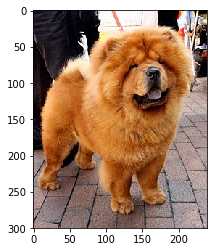

In [49]:
your_dog_breed('dog_test/Chow_Chow.jpg')

This dog is a  in/056.Dachshund


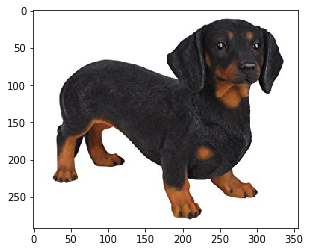

In [51]:
your_dog_breed('dog_test/dachshund.jpg')

This dog is a  in/096.Labrador_retriever


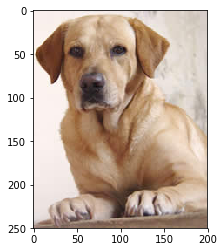

In [52]:
your_dog_breed('dog_test/labrador_retriever.jpg')

This dog is a  in/120.Pharaoh_hound


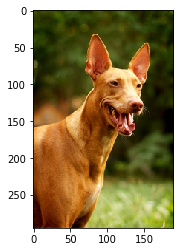

In [53]:
your_dog_breed('dog_test/pharoah_hound.jpg')

This dog is a  in/061.English_cocker_spaniel


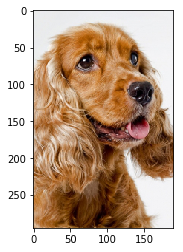

In [54]:
your_dog_breed('dog_test/spaniel.jpg')

__Some human images supplied by me__

This person resembles a in/127.Silky_terrier


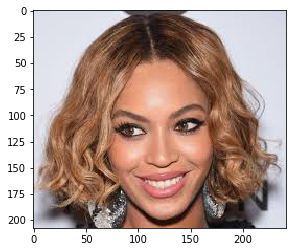

In [26]:
your_dog_breed('human_test/beyonce.jpeg')

This person resembles a in/127.Silky_terrier


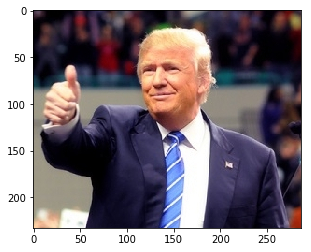

In [28]:
your_dog_breed('human_test/trump.jpg')

This person resembles a in/016.Beagle


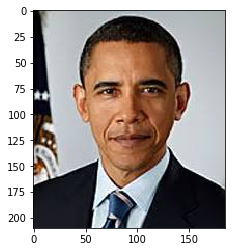

In [27]:
your_dog_breed('human_test/obama.jpeg')

This person resembles a in/007.American_foxhound


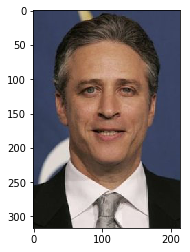

In [61]:
your_dog_breed('human_test/jon_stewart.jpg')

__Images from the given data (test images of dogs and human images from the lfw folder)__

This person resembles a in/014.Basenji


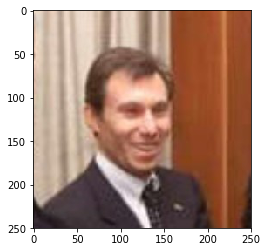

In [62]:
your_dog_breed('/data/lfw/German_Khan/German_Khan_0001.jpg')

This person resembles a in/069.French_bulldog


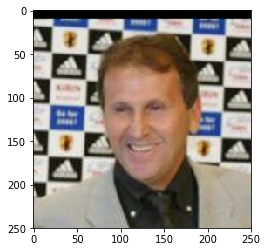

In [63]:
your_dog_breed('/data/lfw/Zico/Zico_0001.jpg')

This person resembles a in/007.American_foxhound


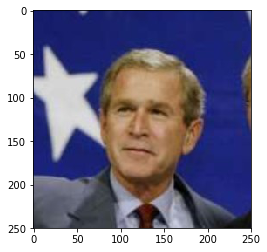

In [64]:
your_dog_breed('/data/lfw/George_W_Bush/George_W_Bush_0001.jpg')

This dog is a  in/083.Ibizan_hound


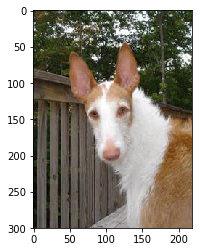

In [65]:
your_dog_breed('/data/dog_images/test/083.Ibizan_hound/Ibizan_hound_05642.jpg')  #correct

I don't see a human face or a dog


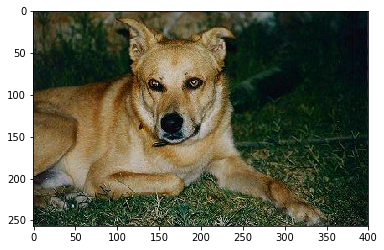

In [70]:
your_dog_breed('/data/dog_images/test/043.Canaan_dog/Canaan_dog_03066.jpg')  #incorrect prediction - to be expected about 20% of the time.

This dog is a  in/024.Bichon_frise


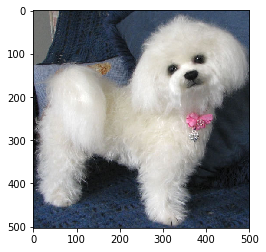

In [67]:
your_dog_breed('/data/dog_images/test/024.Bichon_frise/Bichon_frise_01707.jpg')  #correct